# Outlier 2019: Distant Reading

Literary historian Franco Moretti advocates for an approach to studying literature called _[distant reading](https://en.wikipedia.org/wiki/Distant_reading)_ which applies computational tools to gain insights inaccessible to an individual reader. Generally, we come to appreciate a text by reading it closely. This approach is ideal for one work, but there may be things that only become visible when looking at a large body of material. While you can read everything written by one or even several authors, you cannot read everything that was published during an entire era.  A computer, however, can process millions of texts, and the idea behind distant reading is to analyze a corpus of literature to identify large scale patterns.

There are reviewers who do a great job of providing in-depth looks at individual pieces released by Outlier. For example, Alex Kwa ([reddit](https://www.reddit.com/user/alexkwa), [alexkwa.com](https://alexkwa.com/reviews/)), TheBoyzBoyz ([reddit](https://www.reddit.com/user/theboyzboyz), [IG](https://www.instagram.com/runninthrudastixwithmyclothes/)), or YoungSatchel ([reddit](https://www.reddit.com/user/YoungSatchel/), [IG](https://www.instagram.com/meridian.vision/), and his store [Meridian](https://meridian.vision), which is well worth checking out) all do fantastic product reviews with amazing accompanying photos. But no one can review everything Outlier releases. Nonetheless, there may be some interesting patterns to find by looking at everything Outlier released in the past several years. That is what we will try to do here.

**Questions**
* Growth 
  * drops & products
  * drops * colors
* Clothes
  * Most dropped tops, bottoms
  * Fabrics -- new and lost fabrics
  * Conversions -- Exp to full
* Growth per season

In [1]:
import pandas as pd
import numpy as np
import scipy
import os
import os.path
from IPython.display import display, HTML
import utils
import plots
import altair as alt

style_prefs = utils.StylePrefs()
style_prefs.use()

df_all = utils.outlier_df('../../outlier/public/outlier-data.csv')
# current_month = 12
# df_all = df_all[df_all['Release'].apply(lambda d: d.month < current_month)]

In [2]:
# Filter to Clothes
def type_to_kind(drop_type):
    if drop_type == "T-Shirt" or drop_type == "Shirt" or drop_type == "Tank Top":
        return "Top"
    if drop_type == "Pants" or drop_type == "Shorts":
        return "Bottom"
    return "Layer"

def row_to_subkind(row):
    drop_type = row['Type']
    if drop_type == "T-Shirt" or drop_type == "Shirt":
        pass
    elif drop_type == "Pants" or drop_type == "Shorts":
        pass
    elif drop_type == "Tank Top":
        drop_type = 'T-Shirt'
    else:
        drop_type = "Layer"
    exp = "Exp" if row['Exp'] else "Regular"
    return "{}/{}".format(drop_type, exp)

# Define some reused frames
all_products_df = utils.drops_to_products(df_all, ['Year', 'Product'])
df_all['ColorCount'] = df_all['Colors'].str.split(',').dropna().apply(lambda d: len(d))

df_clothes = pd.DataFrame(df_all.loc[df_all['Category'] == 'Clothes', :])
df_clothes["Kind"] = df_clothes['Type'].apply(type_to_kind)
df_clothes["Subkind"] = df_clothes.apply(row_to_subkind, axis=1)
clothes_products_df = utils.drops_to_products(df_clothes, ['Year', 'Product'])


kind_sort_order = ['Bottom', 'Top', 'Layer']
year_sort = list(range(2019, 2012, -1))

# 2019 Growth

Let's start by looking at the growth in 2019. There are many ways to define growth. An obvious one is to use sales revenue, but I do not have access to those numbers. Just using publicly available information, we can measure growth by looking and number of drops and number of products released.

## Drops and Products

In past years, every year has seen an increase in the number of drops compared to the previous year. Some years, this change is modest (2015), but others more substantial. The number of products does not always increase, though. For example, 2017 was a year of consolidation following a year of growth before.

2019 appears to be a bit different: both the number of drops and the number of products declined compared to the previous year.

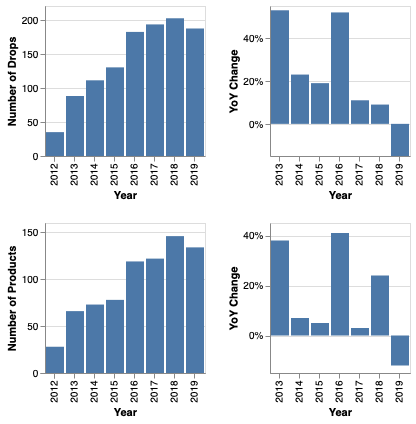

In [3]:
rel_per_year_df = pd.DataFrame(df_all.groupby('Year').count()['Product'])
prod_per_year_df = pd.DataFrame(all_products_df.groupby('Year').count()['Release']
)

plots.plot_with_yoy(rel_per_year_df, 'Product', 'Drops') & plots.plot_with_yoy(prod_per_year_df, 'Release', 'Products')

## Colors

A slightly different picture emerges when we take color into account. There are some that concentrate on a monochrome wardrobe (ahem, [alexkwa.com](https://alexkwa.com/)), but not all of us can rock that look. For those of us that like to color options, 2019 was a good year.

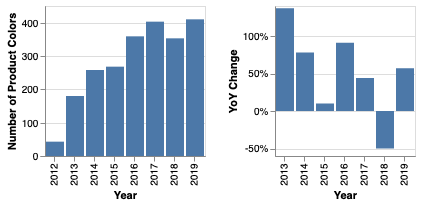

In [4]:
prod_color_year = []
for name, tdf in df_all.groupby(['Year', 'Product']):
    color_ser = tdf['Colors'].str.split(',').dropna()
    colors = set()
    for cs in color_ser:
        colors |= set([c.strip() for c in cs])
    color_count = len(colors) if colors else np.nan
    prod_color_year.append({'Year': name[0], 'Product': name[1], 'Colors': sorted(colors), 'ColorCount': color_count})
prod_color_year_df = pd.DataFrame(prod_color_year)
# prod_color_year_df.head()

plots.plot_with_yoy(prod_color_year_df.groupby('Year').sum(), 'ColorCount', 'Product Colors')

If we include color in our analysis, we see that 2019 has the greatest number of color options available across the product line. It looks like in 2019, as in 2017, there was a focus on offering more colorways rather than more drops or more products.

# 2019 Prices

If you buy Outlier, you'll want to know how prices have been developing. The next plot shows the price of all products, grouped by year. The category of product is indicated by the color of the dot. When comparing prices over a period of years, it is necessary to take inflation into account, which is done here using data from the [St. Louis Fed](https://fred.stlouisfed.org/series/PCEPILFE). The red lines indicate the median product price for that year, adjusted for inflation.

Looking at *all* products, we see that the dispersion of prices has grown and the median price has been quite stable over the last 6 years; the median price has even become a little lower on an inflation-adjusted basis compared to 2012.

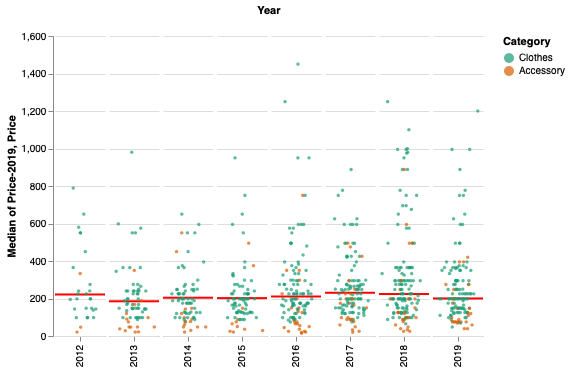

In [5]:
plots.price_plot(all_products_df, color_scale='dark2')

If we focus just on clothes, which make up the bulk of Outlier's products, the situation looks similar. The median product price went up a bit in 2016 and 2017, but has otherwise been pretty stable over the last 7 years.

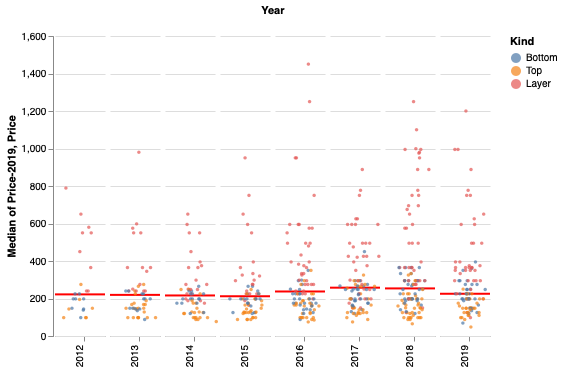

In [6]:
plots.price_plot(clothes_products_df, 'Kind', kind_sort_order)

But if we take layers out of the equation and restrict our view to tops and bottoms, the impression changes a little. Median prices in this case have bounced around a bit more. The current median is a little less than in 2017 but up on an inflation-adjusted basis compared to 2012.

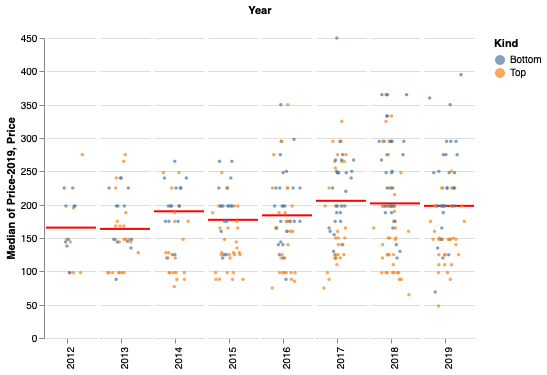

In [8]:
# Same excluding layers
plots.price_plot(clothes_products_df[clothes_products_df['Kind'] != 'Layer'], 'Kind', kind_sort_order)

# Clothes

From year to year, the relative weight of each category of clothing &mdash; bottom, top, layer &mdash; shifts around a bit. In some years, pants and shorts make up the greatest percentage of drops, in others it's shirts and t-shirts.

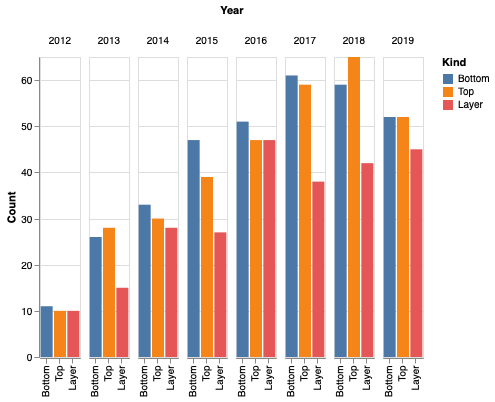

In [10]:
tdf = df_clothes.groupby(['Kind', 'Year']).count()['Release'].reset_index()
tdf.columns = ['Kind', 'Year', 'Count']
alt.Chart(tdf, width=40).mark_bar().encode(
    x=alt.X('Kind:N', sort=kind_sort_order, title=None),
    y='Count:Q',
    color=alt.Color('Kind:N', sort=kind_sort_order),
    column='Year:O',
    tooltip=['Count', ]
).configure_facet(spacing=7)

On a closer inspection, though, it becomes clear that two product types have begun to dominate the Outlier product palette: pants and t-shirts. It wasn't like this a earlier, but this is the way things have developed. In 2019, t-shirts and pants accounted for close to 50% of clothes drops.

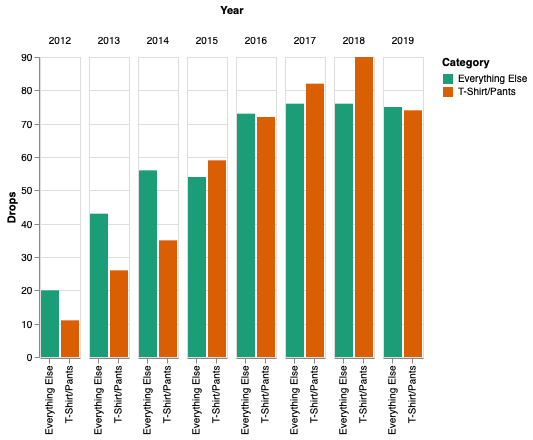

In [11]:
type_count_df = df_clothes.groupby(['Year', 'Type']).count()['Release'].unstack()
ts_pt_ser = type_count_df['T-Shirt'] + type_count_df['Pants']
ts_pt_ser.name = "T-Shirt/Pants"
other_ser = type_count_df.drop(['T-Shirt', 'Pants'], axis=1).sum(axis=1)
other_ser.name = "Everything Else"
tdf = pd.DataFrame([ts_pt_ser, other_ser]).unstack().reset_index()
tdf.columns = ['Year', 'Category', 'Drops']

alt.Chart(tdf, width=40).mark_bar().encode(
    x=alt.X('Category:N', title=None),
    y='Drops:Q',
    color=alt.Color('Category:N', scale=alt.Scale(scheme='dark2')),
    column='Year:O',
    tooltip=['Drops', "Category"]
).configure_facet(spacing=7)

# The Future is Future-?

A t-shirt and pair of pants, the Ultrafine T-Shirt and Slim Dungarees, make up what used to be called the *Core Pack* (now known as the [Travel Pack](https://shop.outlier.nyc/shop/retail/travel-pack.html)). Not surprisingly, these two products have been the most reupped over the last several years, and the undisputed king of the reup has been the SDs; the dominance is even greater if the long length is included in the total.

In [13]:
reups = []
index = []
for name, tdf in df_clothes.groupby("Product"):
    drops = tdf.groupby('Year').count()['Release']
    cat = tdf['Type'].iloc[0]
    kind = tdf['Kind'].iloc[0]
    
    # Products dropped in at 3 times since 2014
    if drops.loc[2014:2019].sum() > 2:
        index.append((kind, cat, name))
        reups.append(drops)
        continue
    # Products dropped at least 2 times in the last two years
    if drops.loc[2018:2019].sum() > 1:
        index.append((kind, cat, name))
        reups.append(drops)
        continue
reups_df = pd.DataFrame(reups, index=pd.MultiIndex.from_tuples(index, names=['Kind', 'Type', 'Product']))
reups_df = reups_df.sort_index()
# reups_df.head()

reup_total_df = reups_df.sum(axis=1).droplevel('Type').reset_index()
reup_total_df.columns = ['Kind', 'Product', 'Reup Count']
reup_total_df = reup_total_df.sort_values('Reup Count', ascending=False).reset_index(drop=True)
reup_total_df['Reup Count'] = pd.to_numeric(reup_total_df['Reup Count'], downcast='integer')
reup_total_df.index = reup_total_df.index + 1
reup_total_df[reup_total_df['Reup Count'] > 7]

,Kind,Product,Reup Count
1,Bottom,Slim Dungarees,50
2,Top,Ultrafine Merino T-Shirt,38
3,Bottom,60/30 Chinos,25
4,Bottom,Futureworks,24
5,Bottom,New Way Shorts,17
6,Bottom,Slim Dungarees (Long),17
7,Bottom,OG Climbers,16
8,Bottom,OG Classics,15
9,Top,GD Cottonweight Merino T-Shirt,12
10,Top,Runweight Merino T-Shirt,12


However, this year, SDs have been overtaken. Although they were the most reupped pants last year, this year, both Futureworks and Futuredarts were reupped more. This year, the Injected Linen Pants, a warm-weather, seasonal product, was reupped as many times as the SDs.

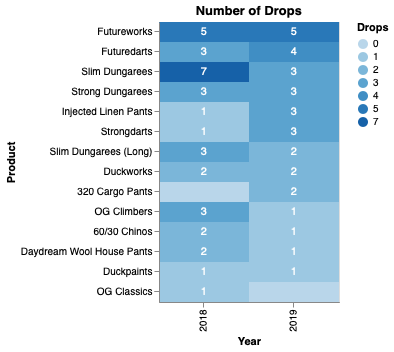

In [32]:
reups_2018_19 = reups_df.loc[:,2018:2019].dropna(how='all')
plots.drop_chart(reups_2018_19.loc[('Bottom', 'Pants')].sort_values([2019, 2018], ascending=False)).properties(title='Number of Drops')

And overall, there has been a bit of shift in the reup dynamics of tops and bottoms. The peak for individual product re-ups was 2016/2017.

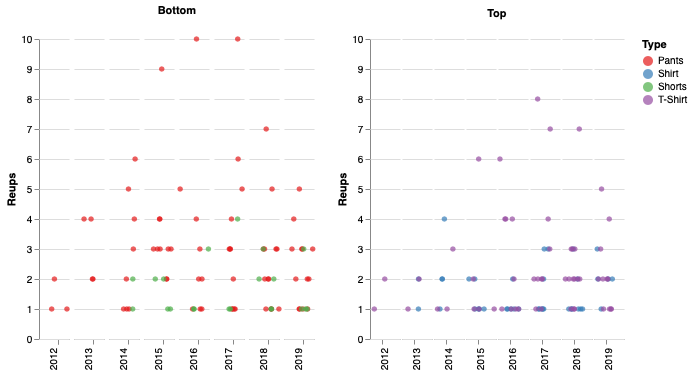

In [21]:
reup_ser = reups_df.stack()
reup_ser.name = 'Reups'
reup_long_df = reup_ser.reset_index()
reupped_products = set(reup_total_df['Product'])
reup_long_df = reup_long_df[reup_long_df['Product'].isin(reupped_products)]
# reup_long_df.head()

plots.reup_plot(reup_long_df)

# Churn in the Shirts

But while the overall numbers of products and drops for non-experimental *pants* didn't change much between 2018 and 2019, 2019 saw the same number of *shirt* drops concentrated in a smaller number of products.

In 2019, we lost the Nyco Oxford, Breezy Linen Pivot, and the Injected Linen Popover from the lineup, these in addition to the Freecotton Button-up, which got dropped last year. 

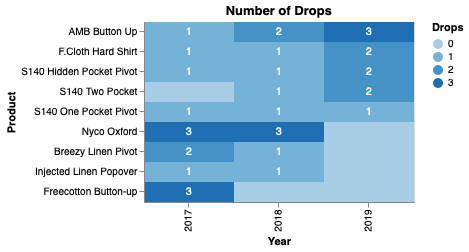

In [33]:
reups_2017_19 = reups_df.loc[:,2017:2019].dropna(how='all')
plots.drop_chart(reups_2017_19.loc[('Top', 'Shirt')].sort_values([2019, 2018, 2017], ascending=False)).properties(title='Number of Drops')

On the whole, there has been a lot of churn in the shirt lineup. In the years since 2013, 13 different shirt models have been reupped more than three times. Only 5 of these were in the 2019 lineup.

Compare this to the pant lineup where 11 of 17 were still in the lineup this year.

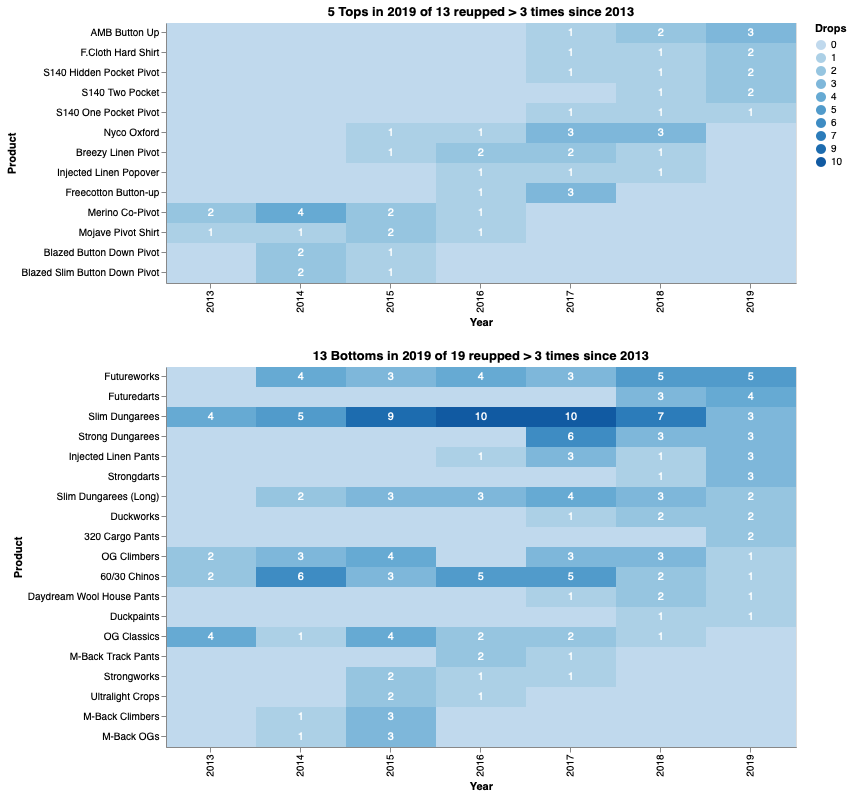

In [23]:
tops_df = reups_df.loc[('Top', 'Shirt'), 2013:2019]
bottoms_df = reups_df.loc[('Bottom', 'Pants'), 2013:2019]
title_tops = "{} Tops in 2019 of {} reupped > 3 times since 2013".format(len(tops_df.loc[:,2019].dropna()), len(tops_df))
title_bottoms = "{} Bottoms in 2019 of {} reupped > 3 times since 2013".format(len(bottoms_df.loc[:,2019].dropna()), len(bottoms_df))
(plots.drop_chart(tops_df.sort_values(year_sort, ascending=False)).properties(title=title_tops) &
plots.drop_chart(bottoms_df.sort_values(year_sort, ascending=False)).properties(title=title_bottoms))

Some of the churn in the shirt lineup is might be attributable to bad luck with fabric suppliers, but that probably is not the entire story. For some reason, Outlier is finding it more difficult to get a shirt setup that they love as much as the SD pants.

# Fabrics

One thing I associate with Outlier is a dedication to fabric. They talk about travelling to the trade shows, looking for distinctive, underutilized fabrics and then iterating in the studio on designs that make the most of their unique qualities.

Since 2012, every year except 2017 has seen an increase in the number of fabrics used in their product palette.

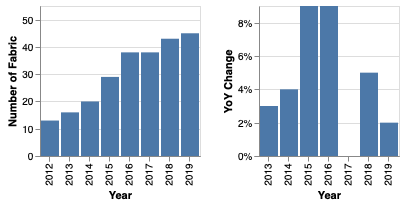

In [25]:
# Fix fabric names
clothes_products_df.loc[clothes_products_df['Fabric'] == 'FU/Cotton Jersey', 'Fabric'] = 'Cotton'
clothes_products_df.loc[clothes_products_df['Fabric'] == 'LA Apparel Cotton', 'Fabric'] = 'Cotton'
fabrics_df = clothes_products_df.groupby(['Fabric', 'Year']).count()['Release'].unstack()
# fabrics_df.head()

fabrics_year_df = pd.DataFrame(fabrics_df.stack().reset_index().groupby('Year').count()['Fabric'])
plots.plot_with_yoy(fabrics_year_df, 'Fabric', 'Fabric')

50% of the fabrics Outlier employs are used in a total of 4 or fewer products.

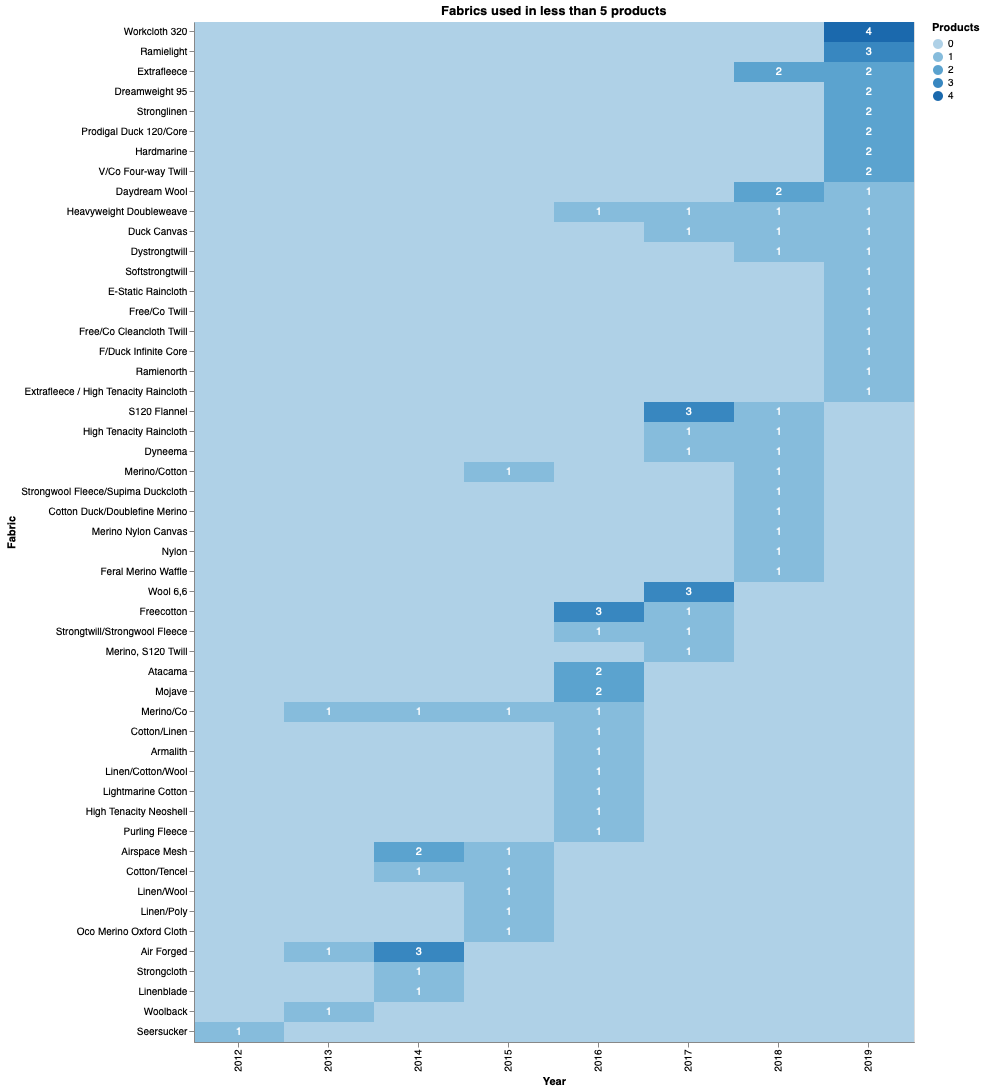

In [27]:
fabrics_cum_ser = fabrics_df.sum(axis=1).sort_values(ascending=False)
fabric_partition = fabrics_cum_ser.describe()

lower_50_fabrics = fabrics_cum_ser[fabrics_cum_ser <= fabric_partition.loc['50%']].index
plots.fabric_chart(fabrics_df.loc[lower_50_fabrics].sort_values(year_sort, ascending=False)).properties(title="Fabrics used in less than 5 products")

Of the remaining 50% of fabrics, which are used in 5 or more products, most have been used in products spanning multiple years. OG and Workcloth have been used in at least two garments every year since since 2012. Cotton and Supermarine Cotton have gone up an down in use. Some, like Doublefine Merino and Ultralight have dropped out of the line-up after many years of service.

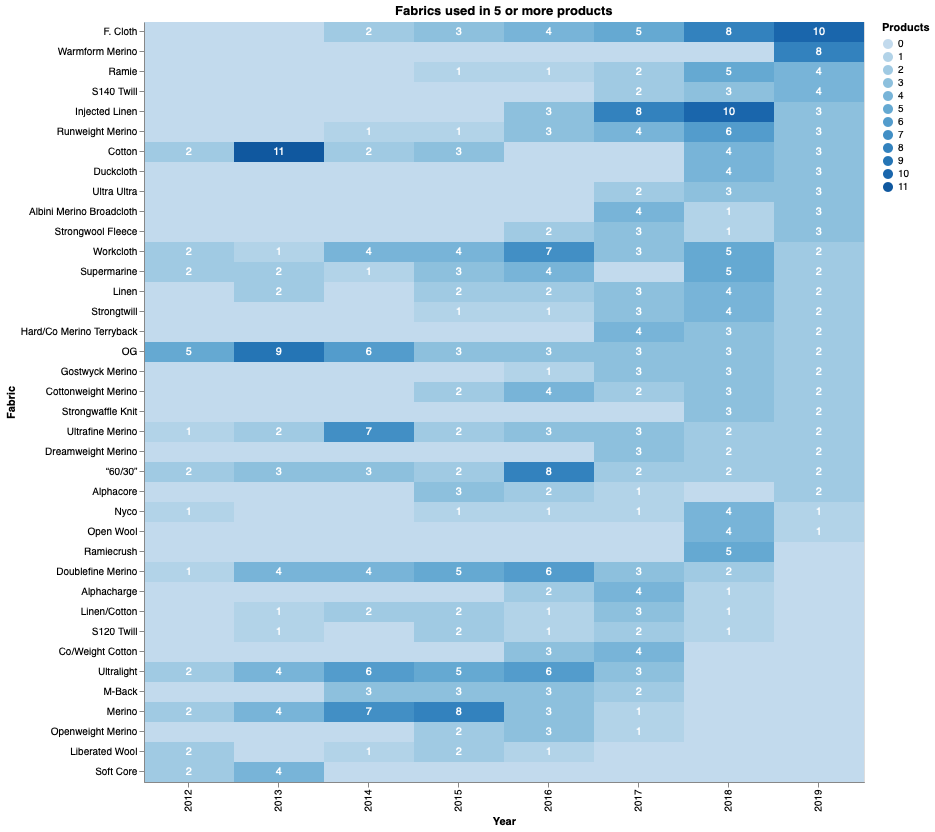

In [28]:
upper_50_fabrics = fabrics_cum_ser[fabrics_cum_ser > fabric_partition.loc['50%']].index
plots.fabric_chart(fabrics_df.loc[upper_50_fabrics].sort_values(year_sort, ascending=False)).properties(title="Fabrics used in 5 or more products")

# Conversions

Since introduction of the distinction between experiments and regular drops, the majority of new products have been introduced as experiments. Only a fraction of the experiments get converted into "regular" products.

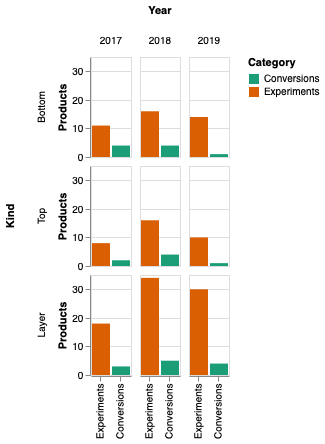

In [30]:
exp_df = df_clothes[(df_clothes['Exp'] == True) & (df_clothes['Year'].isin(range(2016,2020)))]
conversions_df = exp_df[exp_df['Product'] != exp_df['ProductOrig']]

conversions_ser = conversions_df.groupby(['Kind', 'Year']).count()['Release']
conversions_ser.name = 'Conversions'
exps_ser = exp_df.groupby(['Kind', 'Year']).count()['Release'].loc[(slice(None), slice(2017,2019))]
exps_ser.name = 'Experiments'
tdf = pd.concat([conversions_ser, exps_ser], axis=1).stack().reset_index()
tdf.columns = ['Kind', 'Year', 'Category', 'Products']

alt.Chart(tdf, width=40, height=100).mark_bar().encode(
    x=alt.X('Category:N', title=None, sort=['Experiments', 'Conversions']),
    y='Products:Q',
    color=alt.Color('Category:N', scale=alt.Scale(scheme='dark2'), sort=kind_sort_order),
    column='Year:O',
    row=alt.Row('Kind:N', sort=kind_sort_order),
    tooltip=['Products', "Category"]
).configure_facet(spacing=7)

And it's not yet clear how long the products that make it out of the exp phase stay in the lineup. Some of products that go from experiment to regular do not stay around for even one additional year, and many have fewer reups in the subsequent years compared to the first.

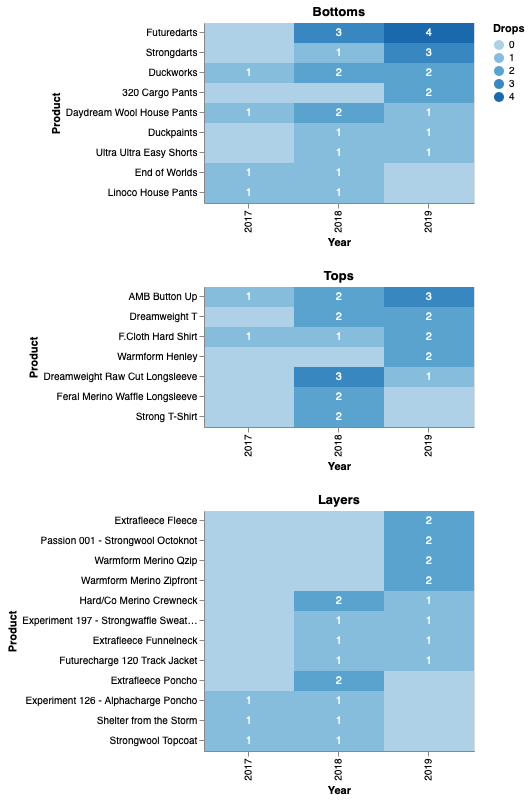

In [31]:
converted_products = pd.unique(conversions_df['Product'])
converted_prods_df = df_clothes.loc[df_clothes['Product'].isin(converted_products)].groupby(['Kind', 'Product', 'Year']).count()['Release'].unstack()

year_sort_order = [2019, 2018, 2017]
(plots.drop_chart(converted_prods_df.loc[('Bottom')].sort_values(year_sort_order, ascending=False)).properties(title='Bottoms') & 
 plots.drop_chart(converted_prods_df.loc[('Top')].sort_values(year_sort_order, ascending=False)).properties(title='Tops') &
 plots.drop_chart(converted_prods_df.loc[('Layer')].sort_values(year_sort_order, ascending=False)).properties(title='Layers'))

# 2020 Prognosis

We have been looking backwards at past releases, but what can we anticipate about the future? What does 2020 hold in store for us? &ldquo;[It's difficult to make predictions, especially about the future](https://quoteinvestigator.com/2013/10/20/no-predict/).&rdquo; If we lived in a [finite-varience world](https://stats.stackexchange.com/questions/94402/what-is-the-difference-between-finite-and-infinite-variance), I would be willing to stick my neck out and stake out some positions for 2020: long Future, long Strong, hold Duck, short Slim.

But it's probably better to be cautious and not go too far out on a limb. If there is any brand that I would expect to provide us with some unexpected surprises, it would be one that uses a [black swan](https://en.wikipedia.org/wiki/Black_swan_theory) as their logo.